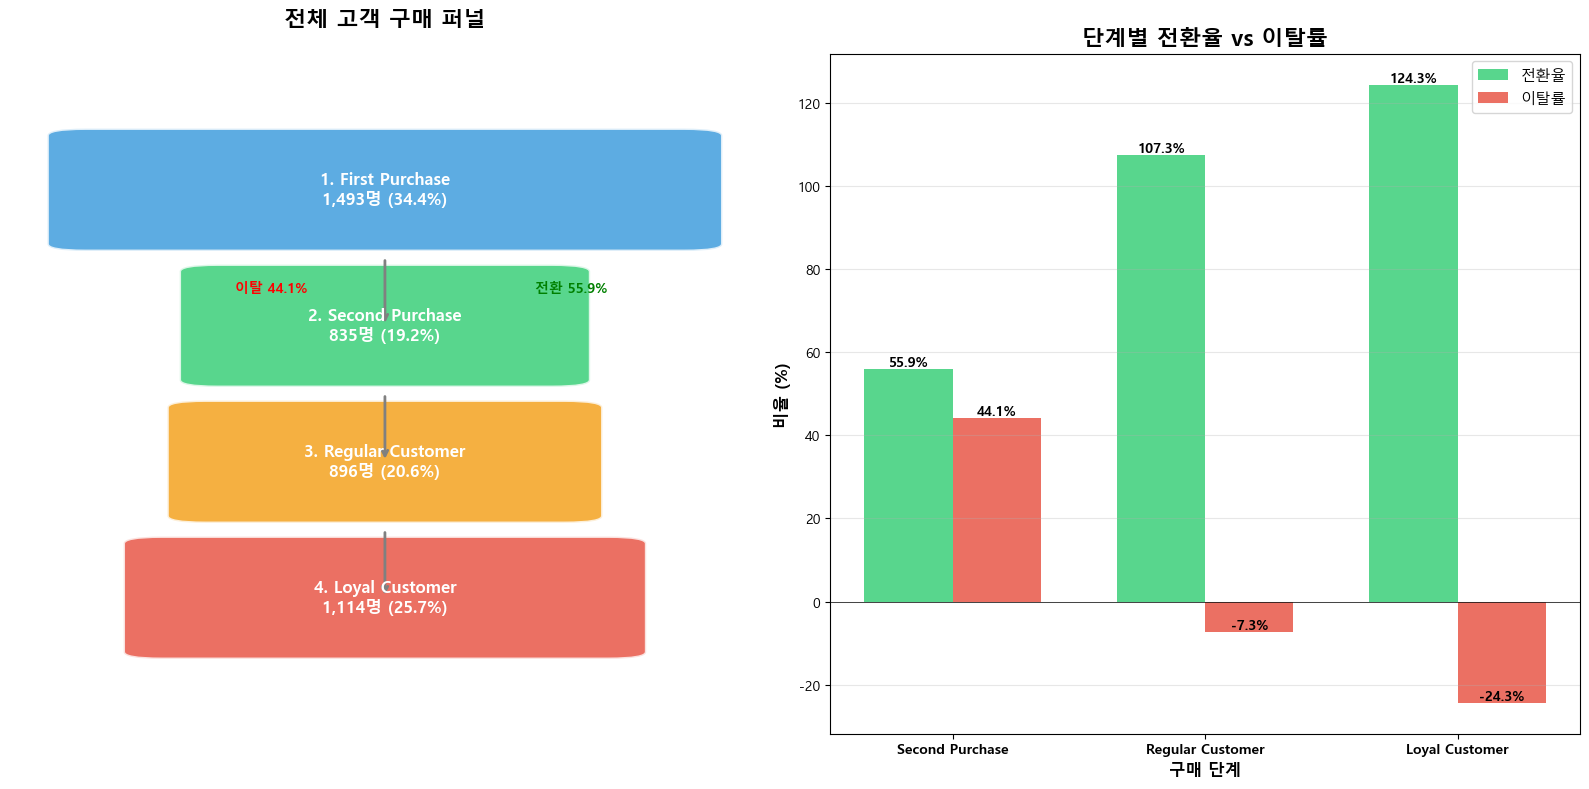

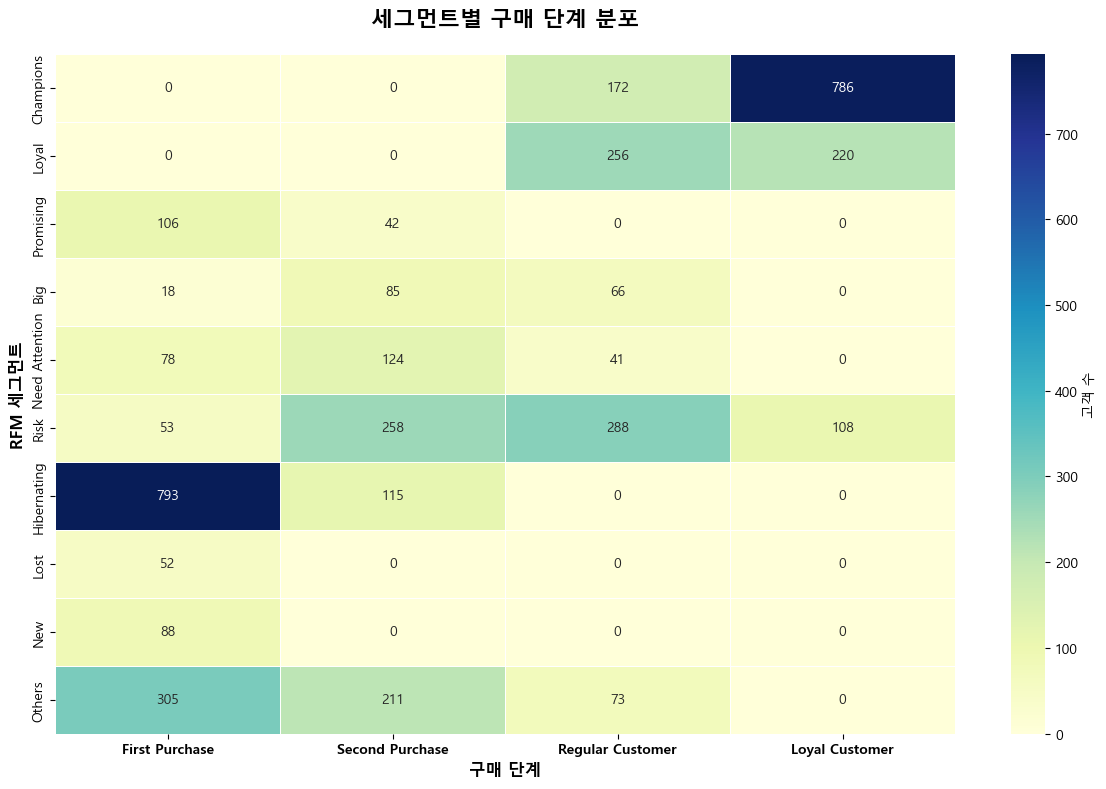

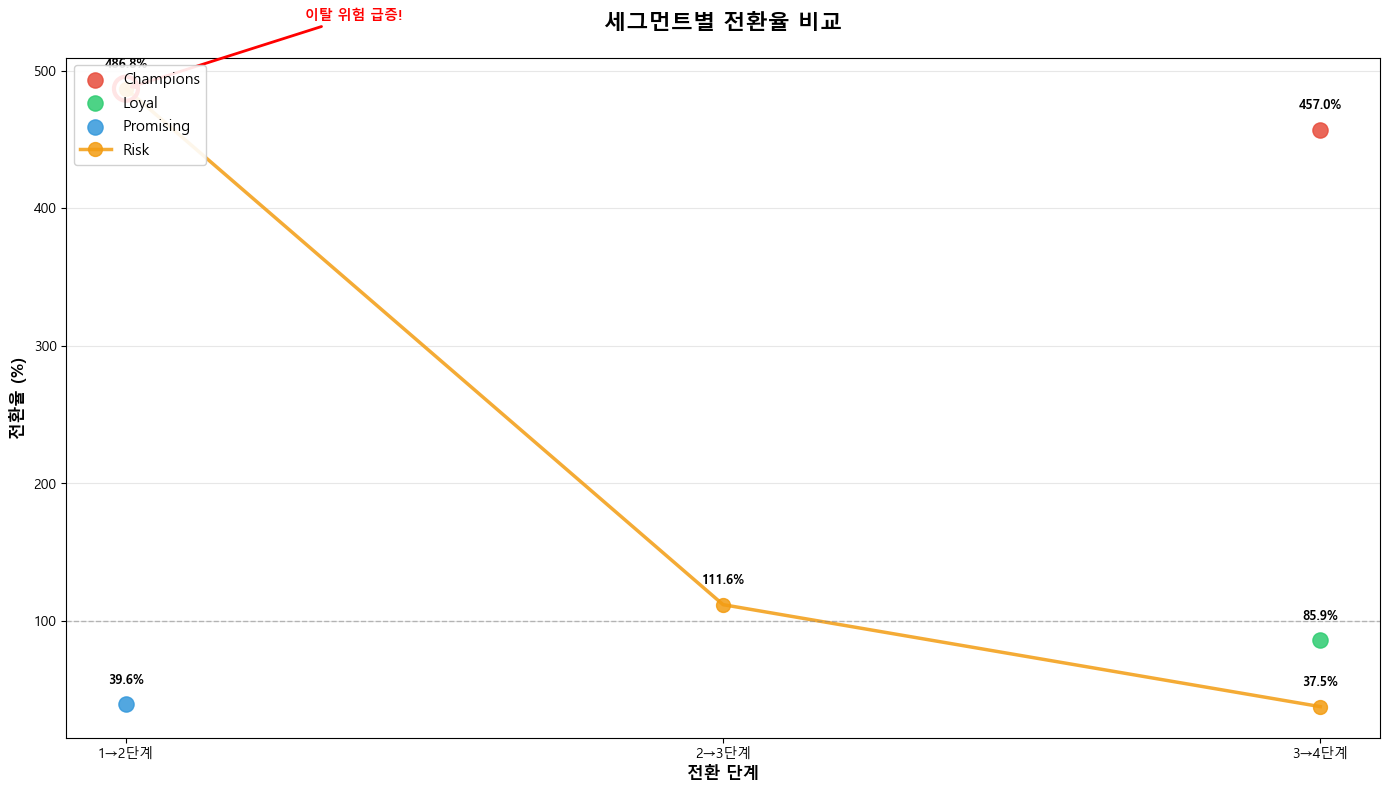

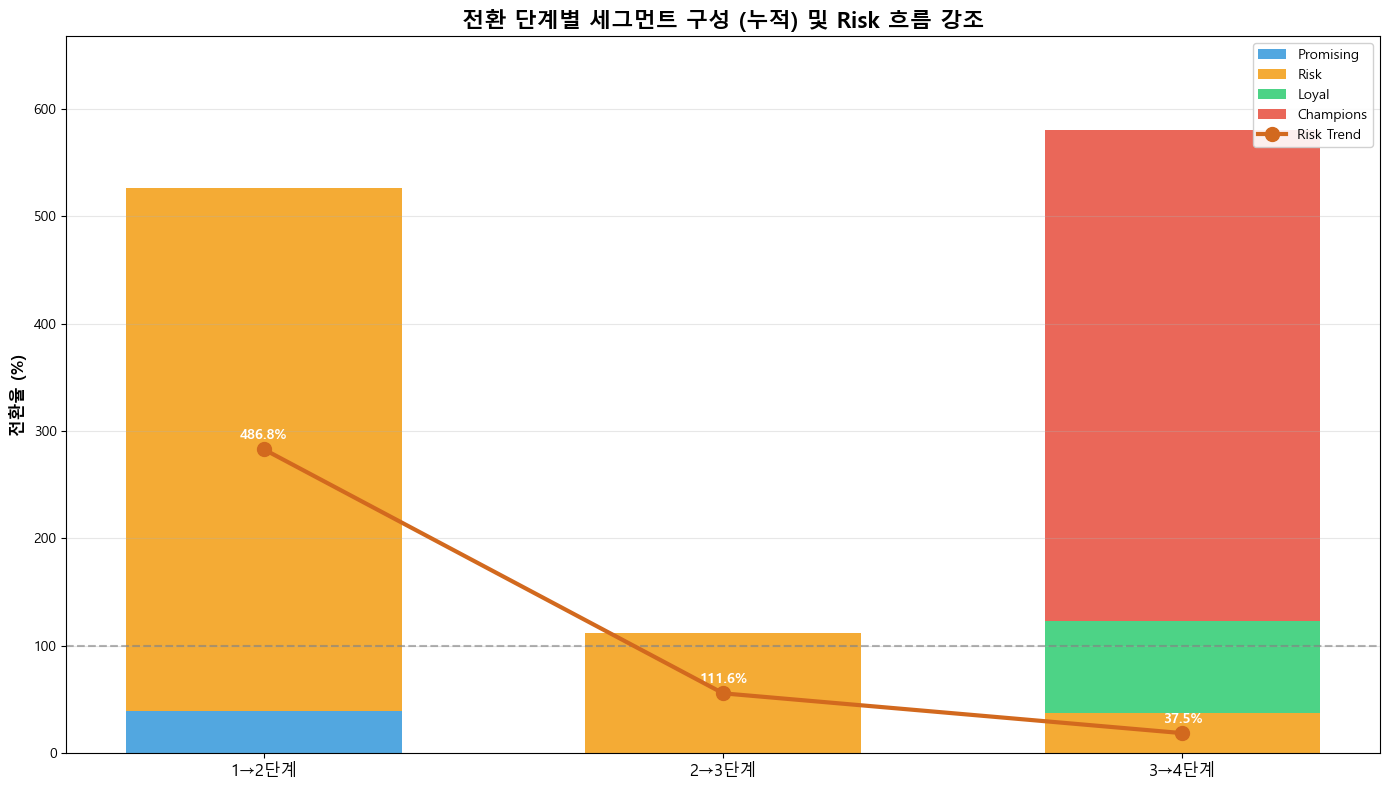

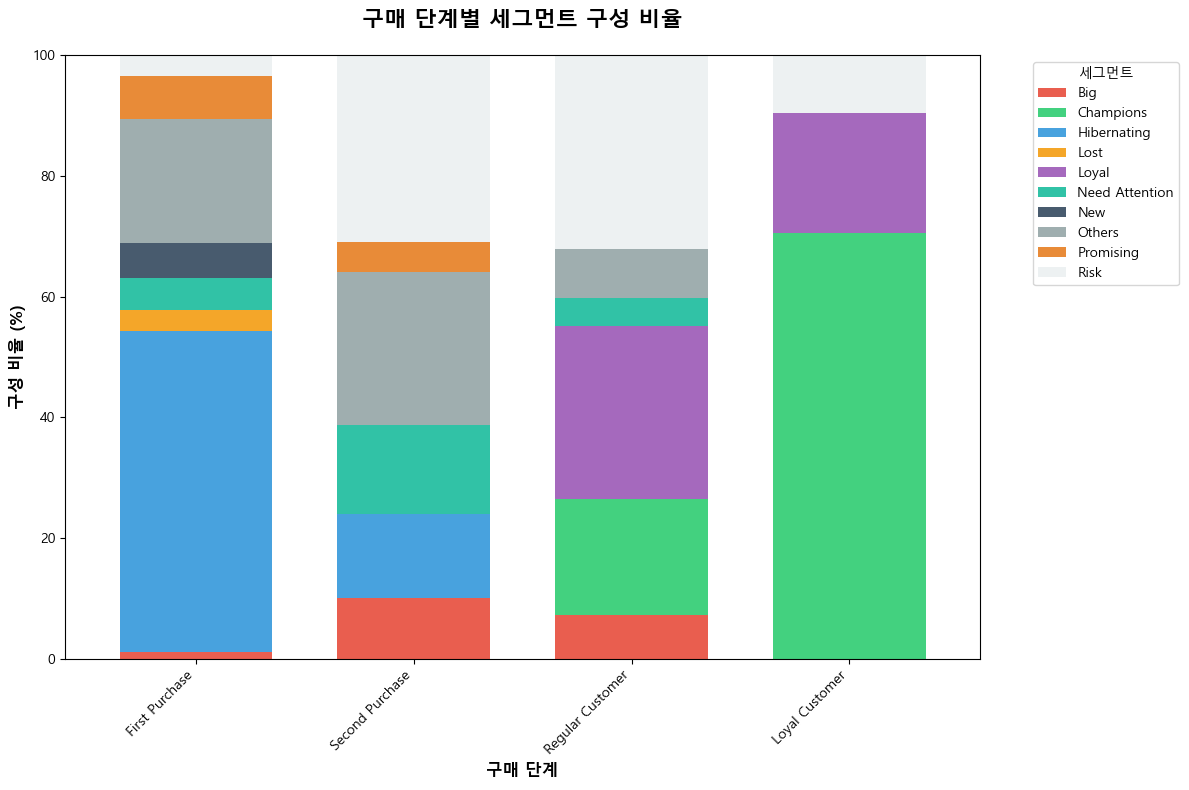

In [55]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# 1. sql 연결 설정
# .env 파일 로드
load_dotenv()

# 환경변수에서 읽기
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

# 연결 엔진 생성
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
# print(engine)

# 2. sql view 불러오기
df = pd.read_sql("SELECT * FROM customer_purchase_stages", engine) #각 고객의 구매 단계(기본 퍼널 뷰)
df_funnel = pd.read_sql("SELECT * FROM funnel_conversion_rates", engine) #전환율 계산 뷰
df_segment_funnel = pd.read_sql("SELECT * FROM funnel_by_rfm_segment", engine) # RFM세그먼트별 퍼널
df_segment_conversion = pd.read_sql("SELECT * FROM funnel_segment_conversion", engine) #RFM세그먼트별 전환율 분석

# 3. 시각화 환경설정
# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False



# =============================================================================
# 1. 전체 퍼널 깔때기 차트 (전환율/이탈율)
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 1-1. 깔때기 차트
stages = df_funnel['purchase_stage'].tolist()
counts = df_funnel['customer_count'].tolist()
percentages = df_funnel['percentage_of_total'].tolist()

# 깔때기 너비 계산 (normalize)
max_count = max(counts)
widths = [count / max_count for count in counts]

# 색상 설정
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

# 깔때기 그리기
y_positions = range(len(stages), 0, -1)
for i, (stage, width, count, pct) in enumerate(zip(stages, widths, counts, percentages)):
    # 직사각형 그리기
    rect_width = width * 0.8
    rect_x = (1 - rect_width) / 2
    
    rect = FancyBboxPatch(
        (rect_x, y_positions[i] - 0.4), rect_width, 0.8,
        boxstyle="round,pad=0.05", 
        facecolor=colors[i], 
        edgecolor='white', 
        linewidth=2,
        alpha=0.8
    )
    ax1.add_patch(rect)
    
    # 텍스트 추가
    ax1.text(0.5, y_positions[i], f'{stage}\n{count:,}명 ({pct:.1f}%)',
             ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    # 전환율 화살표 추가
    if i < len(stages) - 1:
        conversion = df_funnel.loc[i+1, 'conversion_rate']
        drop_off = df_funnel.loc[i+1, 'drop_off_rate']
        
        arrow_y = y_positions[i] - 0.5
        ax1.annotate('', xy=(0.5, arrow_y - 0.5), xytext=(0.5, arrow_y),
                    arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
        
        # 전환율/이탈률 텍스트
        if pd.notna(conversion) and conversion <= 100:
            ax1.text(0.7, arrow_y - 0.25, f'전환 {conversion:.1f}%',
                    fontsize=10, color='green', fontweight='bold')
            ax1.text(0.3, arrow_y - 0.25, f'이탈 {drop_off:.1f}%',
                    fontsize=10, color='red', fontweight='bold')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, len(stages) + 1)
ax1.axis('off')
ax1.set_title('전체 고객 구매 퍼널', fontsize=16, fontweight='bold', pad=20)

# 1-2. 전환율/이탈률 바 차트
stages_with_rate = df_funnel[df_funnel['conversion_rate'].notna()]['purchase_stage'].tolist()
conversions = df_funnel[df_funnel['conversion_rate'].notna()]['conversion_rate'].tolist()
drop_offs = df_funnel[df_funnel['drop_off_rate'].notna()]['drop_off_rate'].tolist()

x = np.arange(len(stages_with_rate))
width = 0.35

bars1 = ax2.bar(x - width/2, conversions, width, label='전환율', color='#2ecc71', alpha=0.8)
bars2 = ax2.bar(x + width/2, drop_offs, width, label='이탈률', color='#e74c3c', alpha=0.8)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xlabel('구매 단계', fontsize=12, fontweight='bold')
ax2.set_ylabel('비율 (%)', fontsize=12, fontweight='bold')
ax2.set_title('단계별 전환율 vs 이탈률', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([s.split('.')[1].strip() for s in stages_with_rate], ha='center',fontweight='bold') #rotation=15,
ax2.legend(fontsize=11)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('01_funnel_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 2. 세그먼트별 구매 단계 분포 (히트맵)
# =============================================================================

# 피벗 테이블 생성
pivot_data = df_segment_funnel.pivot_table(
    index='segment_name', 
    columns='purchase_stage', 
    values='customer_count', 
    fill_value=0
)

# 세그먼트 순서 정의
segment_order = ['Champions', 'Loyal', 'Promising', 'Big', 'Need Attention', 
                 'Risk', 'Hibernating', 'Lost', 'New', 'Others']
pivot_data = pivot_data.reindex(segment_order)

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': '고객 수'},
            linewidths=0.5, linecolor='white', ax=ax, vmin=0)

ax.set_title('세그먼트별 구매 단계 분포', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('구매 단계', fontsize=12, fontweight='bold')
ax.set_ylabel('RFM 세그먼트', fontsize=12, fontweight='bold')
ax.set_xticklabels([s.split('.')[1].strip() for s in pivot_data.columns],ha='center',fontweight='bold') #rotation=45,ha='right'

plt.tight_layout()
plt.savefig('02_segment_stage_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# 3. 세그먼트별 전환율 비교 (강조 포함)
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 8))

# 세그먼트별 색상
segment_colors = {
    'Champions': '#e74c3c',
    'Loyal': '#2ecc71',
    'Promising': '#3498db',
    'Risk': '#f39c12',
    'Lost': '#95a5a6'
}

# 단계 매핑
stage_mapping = {
    '2. Second Purchase': 0,
    '3. Regular Customer': 1,
    '4. Loyal Customer': 2
}

# 세그먼트별로 시각화
for segment in key_segments:
    segment_data = df_key_segments[df_key_segments['segment_name'] == segment].copy()
    
    if segment_data.empty:
        continue
    
    # purchase_stage를 x축 위치로 매핑
    segment_data['x_pos'] = segment_data['purchase_stage'].map(stage_mapping)
    segment_data = segment_data.dropna(subset=['x_pos'])
    
    if segment_data.empty:
        continue
    
    x_data = segment_data['x_pos'].values
    y_data = segment_data['stage_conversion_rate'].values
    
    # Risk는 라인으로, 나머지는 점으로
    if segment == 'Risk':
        ax.plot(x_data, y_data, marker='o', linewidth=2.5, markersize=10,
               label=segment, color=segment_colors[segment], alpha=0.85)
    else:
        ax.scatter(x_data, y_data, s=120, label=segment, 
                  color=segment_colors.get(segment, 'gray'), alpha=0.85)
    
    # 값 표시
    for x, y in zip(x_data, y_data):
        ax.text(x, y + 15, f'{y:.1f}%', ha='center', fontsize=9, fontweight='bold')
    
    # Risk 세그먼트 이탈 위험 구간 강조
    if segment == 'Risk' and len(segment_data) > 1:
        max_idx = segment_data['stage_conversion_rate'].idxmax()
        max_row = segment_data.loc[max_idx]
        max_x = max_row['x_pos']
        ax.scatter(max_x, max_row['stage_conversion_rate'], s=300, 
                  facecolors='none', edgecolors='red', linewidths=3, zorder=5)
        ax.annotate('이탈 위험 급증!', xy=(max_x, max_row['stage_conversion_rate']),
                   xytext=(max_x + 0.3, max_row['stage_conversion_rate'] + 50),
                   fontsize=10, color='red', fontweight='bold',
                   arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.set_xlabel('전환 단계', fontsize=12, fontweight='bold')
ax.set_ylabel('전환율 (%)', fontsize=12, fontweight='bold')
ax.set_title('세그먼트별 전환율 비교', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['1→2단계', '2→3단계', '3→4단계'])
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('03_segment_conversion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 3-2. 세그먼트별 전환율 비교 (누적 + risk 라인 그래프 버전전)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# 단계 매핑
stage_mapping = {
    '2. Second Purchase': 0,
    '3. Regular Customer': 1,
    '4. Loyal Customer': 2
}

stages = ['1→2단계', '2→3단계', '3→4단계']
x = np.arange(len(stages))

# 세그먼트별 색상
segment_colors = {
    'Risk': '#f39c12',
    'Champions': '#e74c3c',
    'Loyal': '#2ecc71', 
    'Promising': '#3498db'
}

# 각 단계별 세그먼트 데이터 수집
stage_data = {i: {} for i in range(3)}

for segment in segment_colors.keys():
    data = df_key_segments[df_key_segments['segment_name'] == segment].copy()
    data['x'] = data['purchase_stage'].map(stage_mapping)
    
    for _, row in data.iterrows():
        if pd.notna(row['x']):
            stage_idx = int(row['x'])
            stage_data[stage_idx][segment] = row['stage_conversion_rate']

# 누적 막대 그리기 (각 단계별로 값 크기 순서대로 정렬)
plotted_segments = set()
risk_positions = []  # Risk의 실제 Y 위치 저장

for stage_idx in range(3):
    # 이 단계의 세그먼트를 값 기준 오름차순 정렬 (작은 것부터 아래에 쌓음)
    stage_segments = sorted(
        stage_data[stage_idx].items(), 
        key=lambda x: x[1]  # value 기준 정렬
    )
    
    bottom = 0
    for segment, value in stage_segments:
        # 범례는 처음 등장할 때만
        label = segment if segment not in plotted_segments else ""
        
        ax.bar(
            stage_idx,
            value,
            bottom=bottom,
            label=label,
            color=segment_colors[segment],
            alpha=0.85,
            width=0.6
        )
        
        plotted_segments.add(segment)
        
        # Risk의 절대 위치 저장 (막대 중간점)
        if segment == 'Risk':
            risk_positions.append((stage_idx, bottom + value / 2))
        
        bottom += value

# Risk 라인 오버레이 (막대의 중간점을 연결)
if risk_positions:
    risk_x = [x for x, y in risk_positions]
    risk_y = [y for x, y in risk_positions]
    
    ax.plot(
        risk_x,
        risk_y,
        color='chocolate',
        marker='o',
        linewidth=3,
        markersize=10,
        label='Risk Trend',
        zorder=5
    )
    
    # Risk 값 텍스트 (실제 전환율)
    for stage_idx in range(3):
        if 'Risk' in stage_data[stage_idx]:
            risk_value = stage_data[stage_idx]['Risk']
            # 해당 단계의 Risk 위치 찾기
            rx = risk_x[risk_positions.index((stage_idx, risk_y[risk_x.index(stage_idx)]))]
            ry = risk_y[risk_x.index(stage_idx)]
            
            ax.text(
                rx, 
                ry+7,  #마커 위로 7만큼 올림 (값 조절 가능)
                f'{risk_value:.1f}%',
                ha='center',
                va='bottom', # 텍스트의 아래쪽이 기준점
                fontsize=10,
                fontweight='bold',
                color='white',
                # bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7)
            )

ax.axhline(100, linestyle='--', color='gray', alpha=0.6, linewidth=1.5)
ax.set_xticks(x)
ax.set_xticklabels(stages, fontsize=12)
ax.set_ylabel('전환율 (%)', fontsize=12, fontweight='bold')
ax.set_title('전환 단계별 세그먼트 구성 (누적) 및 Risk 흐름 강조', fontsize=16, fontweight='bold')

# 범례 정리
handles, labels = ax.get_legend_handles_labels()
# Risk Trend를 마지막으로
if 'Risk Trend' in labels:
    idx = labels.index('Risk Trend')
    handles.append(handles.pop(idx))
    labels.append(labels.pop(idx))
ax.legend(handles, labels, loc='upper right', framealpha=0.9, fontsize=10)

ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max([sum(stage_data[i].values()) for i in range(3)]) * 1.15)

plt.tight_layout()
plt.savefig('04_segment_stacked_with_risk.png', dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# 4. 세그먼트 구성 비율 (Stacked Bar)
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

# 단계별 세그먼트 구성 계산
stage_segment_data = df_segment_funnel.groupby('purchase_stage')['customer_count'].sum().reset_index()
pivot_pct = df_segment_funnel.pivot_table(
    index='purchase_stage', 
    columns='segment_name', 
    values='customer_count', 
    fill_value=0
)

# 비율로 변환
pivot_pct = pivot_pct.div(pivot_pct.sum(axis=1), axis=0) * 100

# 색상 팔레트
colors_palette = ['#e74c3c', '#2ecc71', '#3498db', '#f39c12', '#9b59b6', 
                  '#1abc9c', '#34495e', '#95a5a6', '#e67e22', '#ecf0f1']

# Stacked bar chart
pivot_pct.plot(kind='bar', stacked=True, ax=ax, color=colors_palette[:len(pivot_pct.columns)], 
               width=0.7, alpha=0.9)

ax.set_title('구매 단계별 세그먼트 구성 비율', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('구매 단계', fontsize=12, fontweight='bold')
ax.set_ylabel('구성 비율 (%)', fontsize=12, fontweight='bold')
ax.set_xticklabels([s.split('.')[1].strip() for s in pivot_pct.index], rotation=45, ha='right')
ax.legend(title='세그먼트', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.set_ylim(0, 100)

# 100% 선 추가
ax.axhline(y=100, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('05_stage_segment_composition.png', dpi=300, bbox_inches='tight')
plt.show()


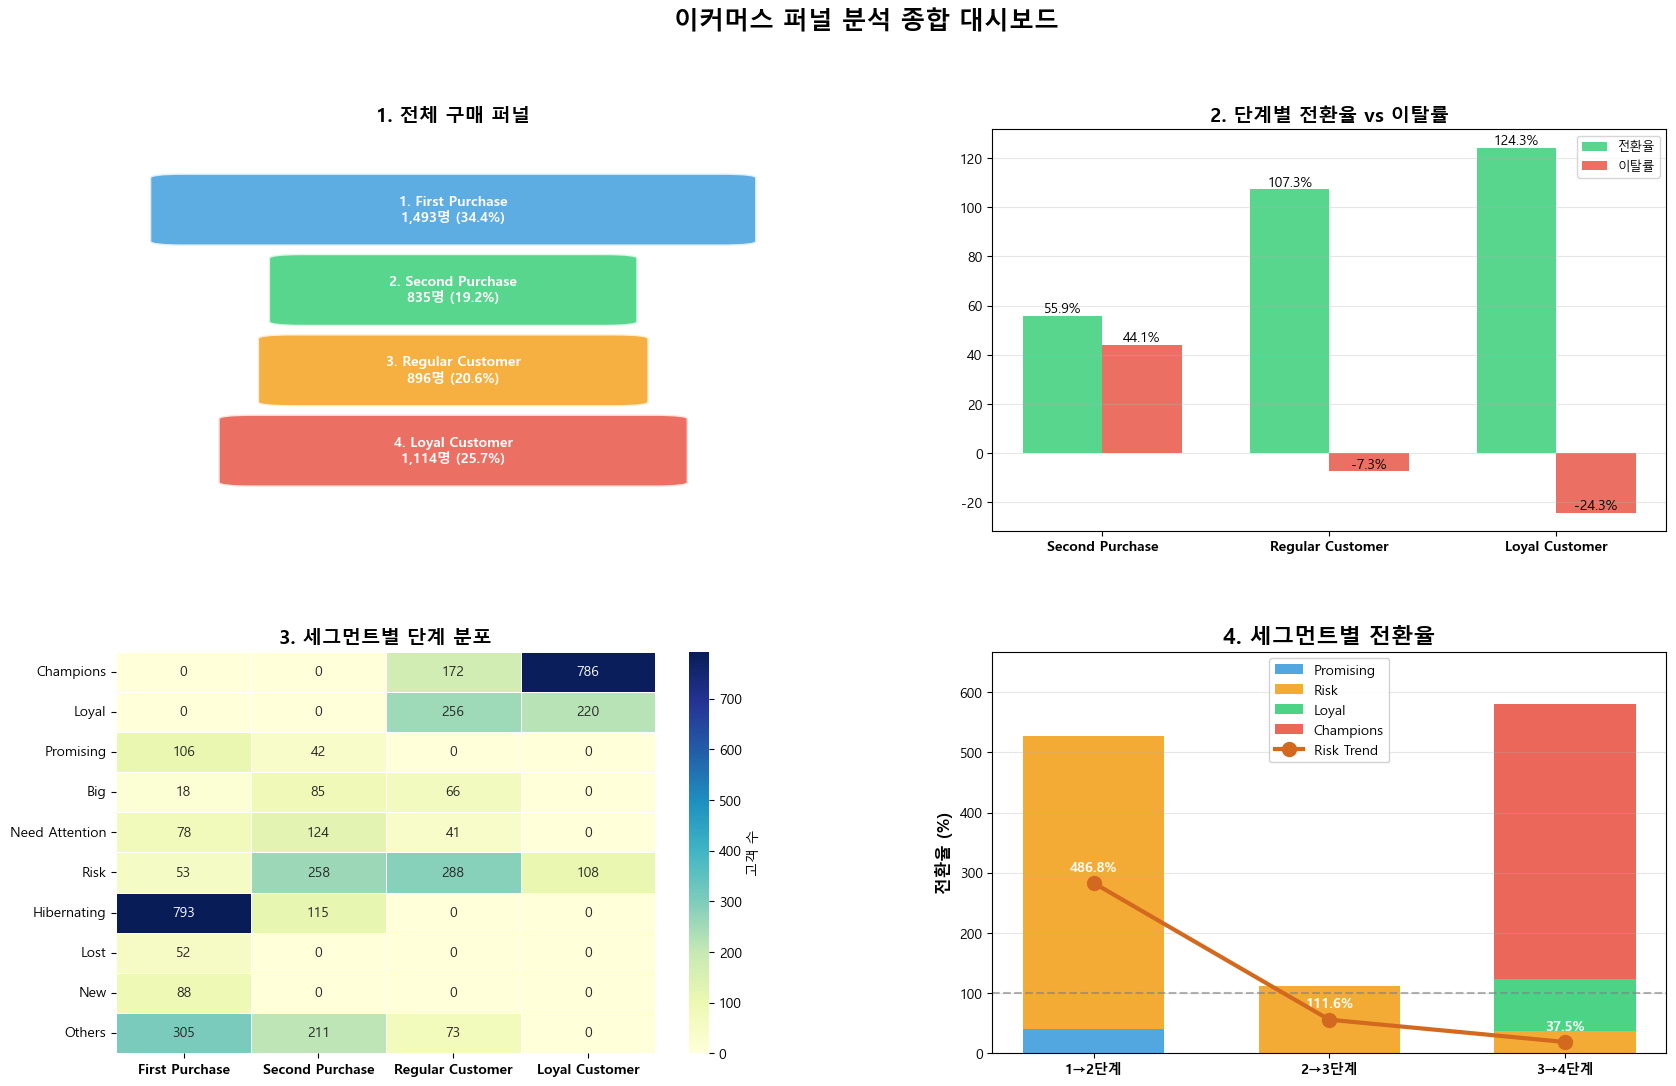


🎉 모든 시각화 완료!
생성된 파일:
  - 01_funnel_overview.png
  - 02_segment_stage_heatmap.png
  - 03_segment_conversion_comparison.png
  - 04_stage_segment_composition.png
  - 05_funnel_dashboard.png


In [56]:
# =============================================================================
# 종합 대시보드 (4개 차트 한 번에)
# =============================================================================
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. 전체 퍼널 (좌상단)
ax1 = fig.add_subplot(gs[0, 0])
stages = df_funnel['purchase_stage'].tolist()
counts = df_funnel['customer_count'].tolist()
percentages = df_funnel['percentage_of_total'].tolist()

widths = [count / max(counts) for count in counts]
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
y_positions = range(len(stages), 0, -1)

for i, (stage, width, count, pct) in enumerate(zip(stages, widths, counts, percentages)):
    rect_width = width * 0.8
    rect_x = (1 - rect_width) / 2
    rect = FancyBboxPatch(
        (rect_x, y_positions[i] - 0.4), rect_width, 0.8,
        boxstyle="round,pad=0.05", facecolor=colors[i], 
        edgecolor='white', linewidth=2, alpha=0.8
    )
    ax1.add_patch(rect)
    ax1.text(0.5, y_positions[i], f'{stage}\n{count:,}명 ({pct:.1f}%)',
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, len(stages) + 1)
ax1.axis('off')
ax1.set_title('1. 전체 구매 퍼널', fontsize=14, fontweight='bold')

# 2. 전환율/이탈률 바 차트 (우상단)
ax2 = fig.add_subplot(gs[0, 1])
stages_with_rate = df_funnel[df_funnel['conversion_rate'].notna()]['purchase_stage'].tolist()
conversions = df_funnel[df_funnel['conversion_rate'].notna()]['conversion_rate'].tolist()
drop_offs = df_funnel[df_funnel['drop_off_rate'].notna()]['drop_off_rate'].tolist()

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
        
x = np.arange(len(stages_with_rate))
width = 0.35
ax2.bar(x - width/2, conversions, width, label='전환율', color='#2ecc71', alpha=0.8)
ax2.bar(x + width/2, drop_offs, width, label='이탈률', color='#e74c3c', alpha=0.8)
ax2.set_title('2. 단계별 전환율 vs 이탈률', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([s.split('.')[1].strip() for s in stages_with_rate],ha='center',fontweight='bold')  #로테이션 수정
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. 히트맵 (좌하단)
ax3 = fig.add_subplot(gs[1, 0])
sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlGnBu', 
            cbar_kws={'label': '고객 수'}, linewidths=0.5, ax=ax3, vmin=0)
ax3.set_title('3. 세그먼트별 단계 분포', fontsize=14, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xticklabels([s.split('.')[1].strip() for s in pivot_data.columns], ha='center',fontweight='bold') #원래 rotation=45, ha='right'

# 4. 세그먼트 비교 (우하단)
ax4 = fig.add_subplot(gs[1, 1])

# # 단계 매핑
# stage_mapping = {
#     '2. Second Purchase': 0,
#     '3. Regular Customer': 1,
#     '4. Loyal Customer': 2
# }

# for segment in key_segments:
#     segment_data = df_key_segments[df_key_segments['segment_name'] == segment].copy()
    
#     if segment_data.empty:
#         continue
    
#     segment_data['x_pos'] = segment_data['purchase_stage'].map(stage_mapping)
#     segment_data = segment_data.dropna(subset=['x_pos'])
    
#     if segment_data.empty:
#         continue
    
#     x_data = segment_data['x_pos'].values
#     y_data = segment_data['stage_conversion_rate'].values
    
#     # Risk는 라인, 나머지는 점
#     if segment == 'Risk':
#         ax4.plot(x_data, y_data, marker='o', linewidth=2, markersize=8,
#                 label=segment, color=segment_colors.get(segment, 'gray'), alpha=0.85)
#     else:
#         ax4.scatter(x_data, y_data, s=80, label=segment, 
#                    color=segment_colors.get(segment, 'gray'), alpha=0.85)

# ax4.set_title('4. 세그먼트별 전환율', fontsize=14, fontweight='bold')
# ax4.set_xticks([0, 1, 2])
# ax4.set_xticklabels(['1→2', '2→3', '3→4'], fontsize=9)
# ax4.legend(fontsize=9, loc='upper left')
# ax4.grid(axis='y', alpha=0.3)
# ax4.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# plt.suptitle('이커머스 퍼널 분석 종합 대시보드', fontsize=18, fontweight='bold', y=0.98)
# # plt.savefig('07_funnel_dashboard.png', dpi=300, bbox_inches='tight')
# plt.show()

############4. 세그먼트별 전환율 ->위의 dot버전 할지 아래 누적 버전 보일지 선택

# 단계 매핑
stage_mapping = {
    '2. Second Purchase': 0,
    '3. Regular Customer': 1,
    '4. Loyal Customer': 2
}

stages = ['1→2단계', '2→3단계', '3→4단계']
x = np.arange(len(stages))

# 세그먼트별 색상
segment_colors = {
    'Risk': '#f39c12',
    'Champions': '#e74c3c',
    'Loyal': '#2ecc71', 
    'Promising': '#3498db'
}

# 각 단계별 세그먼트 데이터 수집
stage_data = {i: {} for i in range(3)}

for segment in segment_colors.keys():
    data = df_key_segments[df_key_segments['segment_name'] == segment].copy()
    data['x'] = data['purchase_stage'].map(stage_mapping)
    
    for _, row in data.iterrows():
        if pd.notna(row['x']):
            stage_idx = int(row['x'])
            stage_data[stage_idx][segment] = row['stage_conversion_rate']

# 누적 막대 그리기 (각 단계별로 값 크기 순서대로 정렬)
plotted_segments = set()
risk_positions = []  # Risk의 실제 Y 위치 저장

for stage_idx in range(3):
    # 이 단계의 세그먼트를 값 기준 오름차순 정렬 (작은 것부터 아래에 쌓음)
    stage_segments = sorted(
        stage_data[stage_idx].items(), 
        key=lambda x: x[1]  # value 기준 정렬
    )
    
    bottom = 0
    for segment, value in stage_segments:
        # 범례는 처음 등장할 때만
        label = segment if segment not in plotted_segments else ""
        
        ax4.bar(
            stage_idx,
            value,
            bottom=bottom,
            label=label,
            color=segment_colors[segment],
            alpha=0.85,
            width=0.6
        )
        
        plotted_segments.add(segment)
        
        # Risk의 절대 위치 저장 (막대 중간점)
        if segment == 'Risk':
            risk_positions.append((stage_idx, bottom + value / 2))
        
        bottom += value

# Risk 라인 오버레이 (막대의 중간점을 연결)
if risk_positions:
    risk_x = [x for x, y in risk_positions]
    risk_y = [y for x, y in risk_positions]
    
    ax4.plot(
        risk_x,
        risk_y,
        color='chocolate',
        marker='o',
        linewidth=3,
        markersize=10,
        label='Risk Trend',
        zorder=5
    )
    
    # Risk 값 텍스트 (실제 전환율)
    for stage_idx in range(3):
        if 'Risk' in stage_data[stage_idx]:
            risk_value = stage_data[stage_idx]['Risk']
            # 해당 단계의 Risk 위치 찾기
            rx = risk_x[risk_positions.index((stage_idx, risk_y[risk_x.index(stage_idx)]))]
            ry = risk_y[risk_x.index(stage_idx)]
            
            ax4.text(
                rx, 
                ry+15,  #마커 위로 n만큼 올림 (값 조절 가능)
                f'{risk_value:.1f}%',
                ha='center',
                va='bottom', # 텍스트의 아래쪽이 기준점
                fontsize=10,
                fontweight='bold',
                color='white',
                # bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7)
            )

ax4.axhline(100, linestyle='--', color='gray', alpha=0.6, linewidth=1.5)
ax4.set_xticks(x)
ax4.set_xticklabels(stages, fontsize=10,fontweight='bold')
ax4.set_ylabel('전환율 (%)', fontsize=12, fontweight='bold')
ax4.set_title('4. 세그먼트별 전환율', fontsize=16, fontweight='bold')

# 범례 정리
handles, labels = ax4.get_legend_handles_labels()
# Risk Trend를 마지막으로
if 'Risk Trend' in labels:
    idx = labels.index('Risk Trend')
    handles.append(handles.pop(idx))
    labels.append(labels.pop(idx))
ax4.legend(handles, labels, loc='best', framealpha=0.9, fontsize=10)  #upper right

ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, max([sum(stage_data[i].values()) for i in range(3)]) * 1.15)

plt.suptitle('이커머스 퍼널 분석 종합 대시보드', fontsize=18, fontweight='bold', y=0.98)
plt.savefig('06_funnel_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()




print("\n" + "="*60)
print("🎉 모든 시각화 완료!")
print("="*60)
print("생성된 파일:")
print("  - 01_funnel_overview.png")
print("  - 02_segment_stage_heatmap.png")
print("  - 03_segment_conversion_comparison.png")
print("  - 04_stage_segment_composition.png")
print("  - 05_funnel_dashboard.png")
print("="*60)